## Mounting Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls drive/MyDrive/Dataset

Mounted at /content/drive
dengue_features_test.csv   dengue_labels_train.csv
dengue_features_train.csv  submission_format.csv


## Importing needed libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import seaborn as sns
sns.set()
from statsmodels.tsa.seasonal import seasonal_decompose as decompose
from pandas import Series

## Read the dataset

In [3]:
df = pd.read_csv('drive/MyDrive/Dataset/dengue_features_train.csv')
df_labels = pd.read_csv('drive/MyDrive/Dataset/dengue_labels_train.csv')

## Counting number of Null values in each column

In [4]:
df.isnull().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

In [5]:
df_labels.isnull().sum()

city           0
year           0
weekofyear     0
total_cases    0
dtype: int64

## Counting number of rows and number of columns in the dataset

In [6]:
print(f"Number of attributes {len(df.columns)}")
print(f"Number of rows {len(df)}")

Number of attributes 24
Number of rows 1456


## Convert *week_start_date* object into dateTime object

In [7]:
df['week_start_date'] = pd.to_datetime(df['week_start_date'])

## Join the tables of training dataset with targets based on common columns of *year* ,*weekofyear*,*city*

In [8]:
df_cases_time = pd.merge(df,df_labels,on=["year","weekofyear","city"])
print_cols = ["city","year","weekofyear","week_start_date","total_cases"]
print(df_cases_time[print_cols])

     city  year  weekofyear week_start_date  total_cases
0      sj  1990          18      1990-04-30            4
1      sj  1990          19      1990-05-07            5
2      sj  1990          20      1990-05-14            4
3      sj  1990          21      1990-05-21            3
4      sj  1990          22      1990-05-28            6
...   ...   ...         ...             ...          ...
1451   iq  2010          21      2010-05-28            5
1452   iq  2010          22      2010-06-04            8
1453   iq  2010          23      2010-06-11            1
1454   iq  2010          24      2010-06-18            1
1455   iq  2010          25      2010-06-25            4

[1456 rows x 5 columns]


## Indexing with *week_start_date* 

In [9]:
df_cases_time = df_cases_time.set_index('week_start_date')

## City sj data

In [10]:
df_labels_sj = df_cases_time[df_cases_time["city"]=='sj']
print(df_labels_sj.head(5))

                city  year  weekofyear   ndvi_ne   ndvi_nw   ndvi_se  \
week_start_date                                                        
1990-04-30        sj  1990          18  0.122600  0.103725  0.198483   
1990-05-07        sj  1990          19  0.169900  0.142175  0.162357   
1990-05-14        sj  1990          20  0.032250  0.172967  0.157200   
1990-05-21        sj  1990          21  0.128633  0.245067  0.227557   
1990-05-28        sj  1990          22  0.196200  0.262200  0.251200   

                  ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  \
week_start_date                                                          
1990-04-30       0.177617                 12.42             297.572857   
1990-05-07       0.155486                 22.82             298.211429   
1990-05-14       0.170843                 34.54             298.781429   
1990-05-21       0.235886                 15.36             298.987143   
1990-05-28       0.247340                  7.52    

## City iq data

In [11]:
#iq city labels
df_labels_iq = df_cases_time[df_cases_time["city"]=='iq']
print(df_labels_iq.head(5))

                city  year  weekofyear   ndvi_ne   ndvi_nw   ndvi_se  \
week_start_date                                                        
2000-07-01        iq  2000          26  0.192886  0.132257  0.340886   
2000-07-08        iq  2000          27  0.216833  0.276100  0.289457   
2000-07-15        iq  2000          28  0.176757  0.173129  0.204114   
2000-07-22        iq  2000          29  0.227729  0.145429  0.254200   
2000-07-29        iq  2000          30  0.328643  0.322129  0.254371   

                  ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  \
week_start_date                                                          
2000-07-01       0.247200                 25.41             296.740000   
2000-07-08       0.241657                 60.61             296.634286   
2000-07-15       0.128014                 55.52             296.415714   
2000-07-22       0.200314                  5.60             295.357143   
2000-07-29       0.361043                 62.76    

## Line plot to vizualize *Number of cases vs time*,*Humidity vs time* and *temperature vs time*

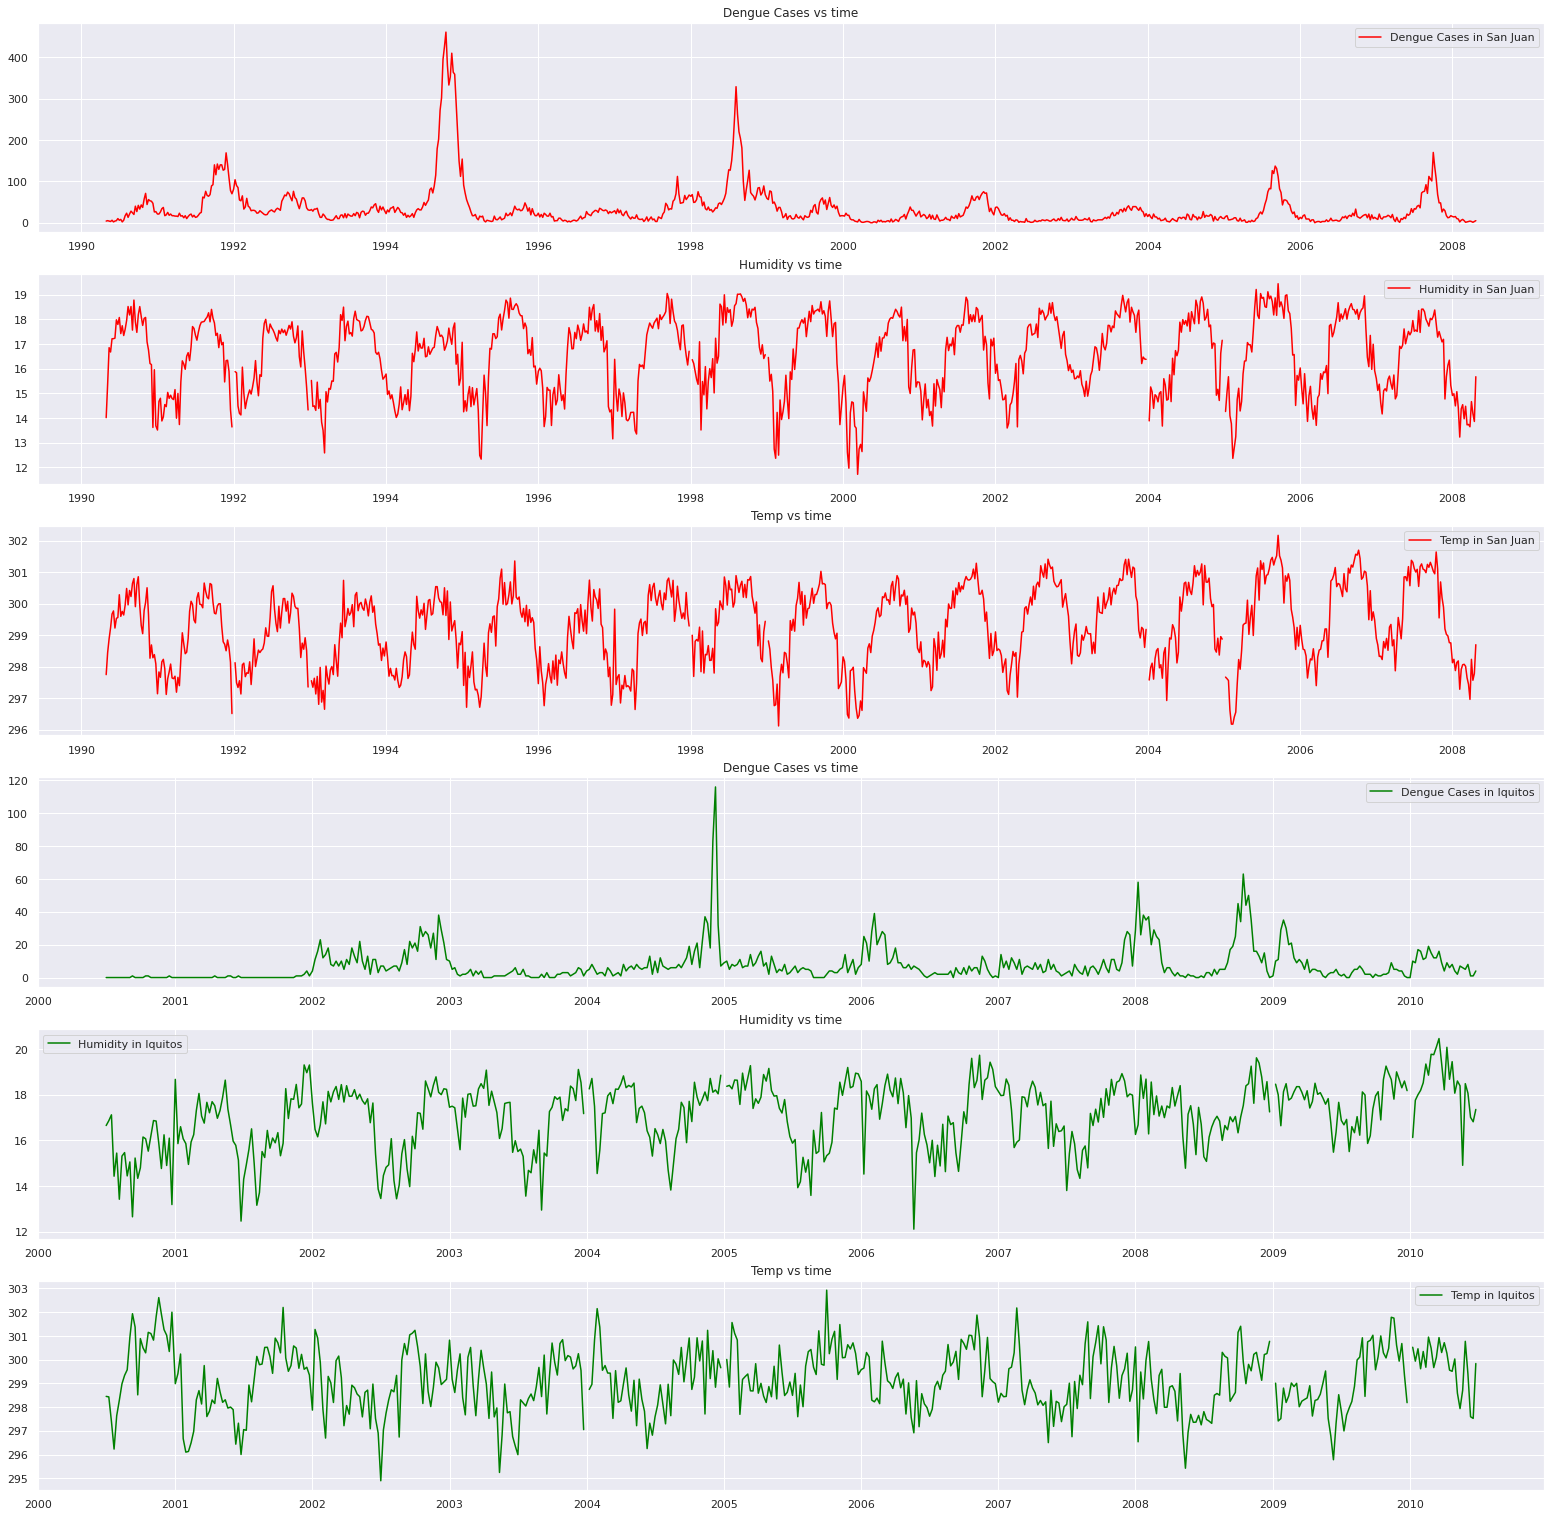

In [12]:
plt.rcParams['figure.figsize']=(27,27) #rc -> runtime config
fig,ax = plt.subplots(6, 1) 

all_concerns = [
             'total_cases',
             'reanalysis_specific_humidity_g_per_kg',
             'reanalysis_avg_temp_k'
             ]
labels=[
        'Dengue Cases',
        'Humidity',
        'Temp'
]

colors=["red","green"]
# for j,city in enumerate(["sj","iq"]):
#   if city=="sj":   use_df = df_labels_sj
#   elif city=="iq": use_df = df_labels_iq
#   else:
#       print("Invalid city")
#       break

for i,concern in enumerate(all_concerns):
  ax[i].plot(
      df_labels_sj.index,
      df_labels_sj[concern],
      color=colors[0],
      label=f"{labels[i]} in San Juan"
  )
  ax[i].set_title(f"{labels[i]} vs time")
  ax[i].legend()

for i,concern in enumerate(all_concerns):
  ax[i+3].plot(
      df_labels_iq.index,
      df_labels_iq[concern],
      color=colors[1],
      label=f"{labels[i]} in Iquitos"
  )
  ax[i+3].set_title(f"{labels[i]} vs time")
  ax[i+3].legend()
        

plt.show()

## Finding number of duplicate rows

In [13]:
duplicate_rows_df = df[df.duplicated()]
duplicate_rows_df.shape

(0, 24)

## Finding the number of yearly cases for the cities sj and iq

In [14]:
df_sj = df_labels[df_labels['city']=='sj']

df_sj_yearly = None
df_sj["yearly_cases"] = df_sj.groupby(["year"])["total_cases"].transform('sum') #group by each year and sum the totoal monthly cases

df_sj_yearly = df_sj[["year","yearly_cases"]]
df_sj_yearly=df_sj_yearly.drop_duplicates() #remove values stored for same year

df_iq_yearly = None
df_iq = df_labels[df_labels["city"]=="iq"]

df_iq["yearly_cases"] = df_iq.groupby(["year"])["total_cases"].transform('sum')
df_iq_yearly = df_iq[["year","yearly_cases"]]
df_iq_yearly=df_iq_yearly.drop_duplicates() #remove values stored for same year

/tmp/ipykernel_39257/1046404560.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sj["yearly_cases"] = df_sj.groupby(["year"])["total_cases"].transform('sum') #group by each year and sum the totoal monthly cases
/tmp/ipykernel_39257/1046404560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iq["yearly_cases"] = df_iq.groupby(["year"])["total_cases"].transform('sum')


## Box-Plots to visualize outliers in the number of cases for both the cities

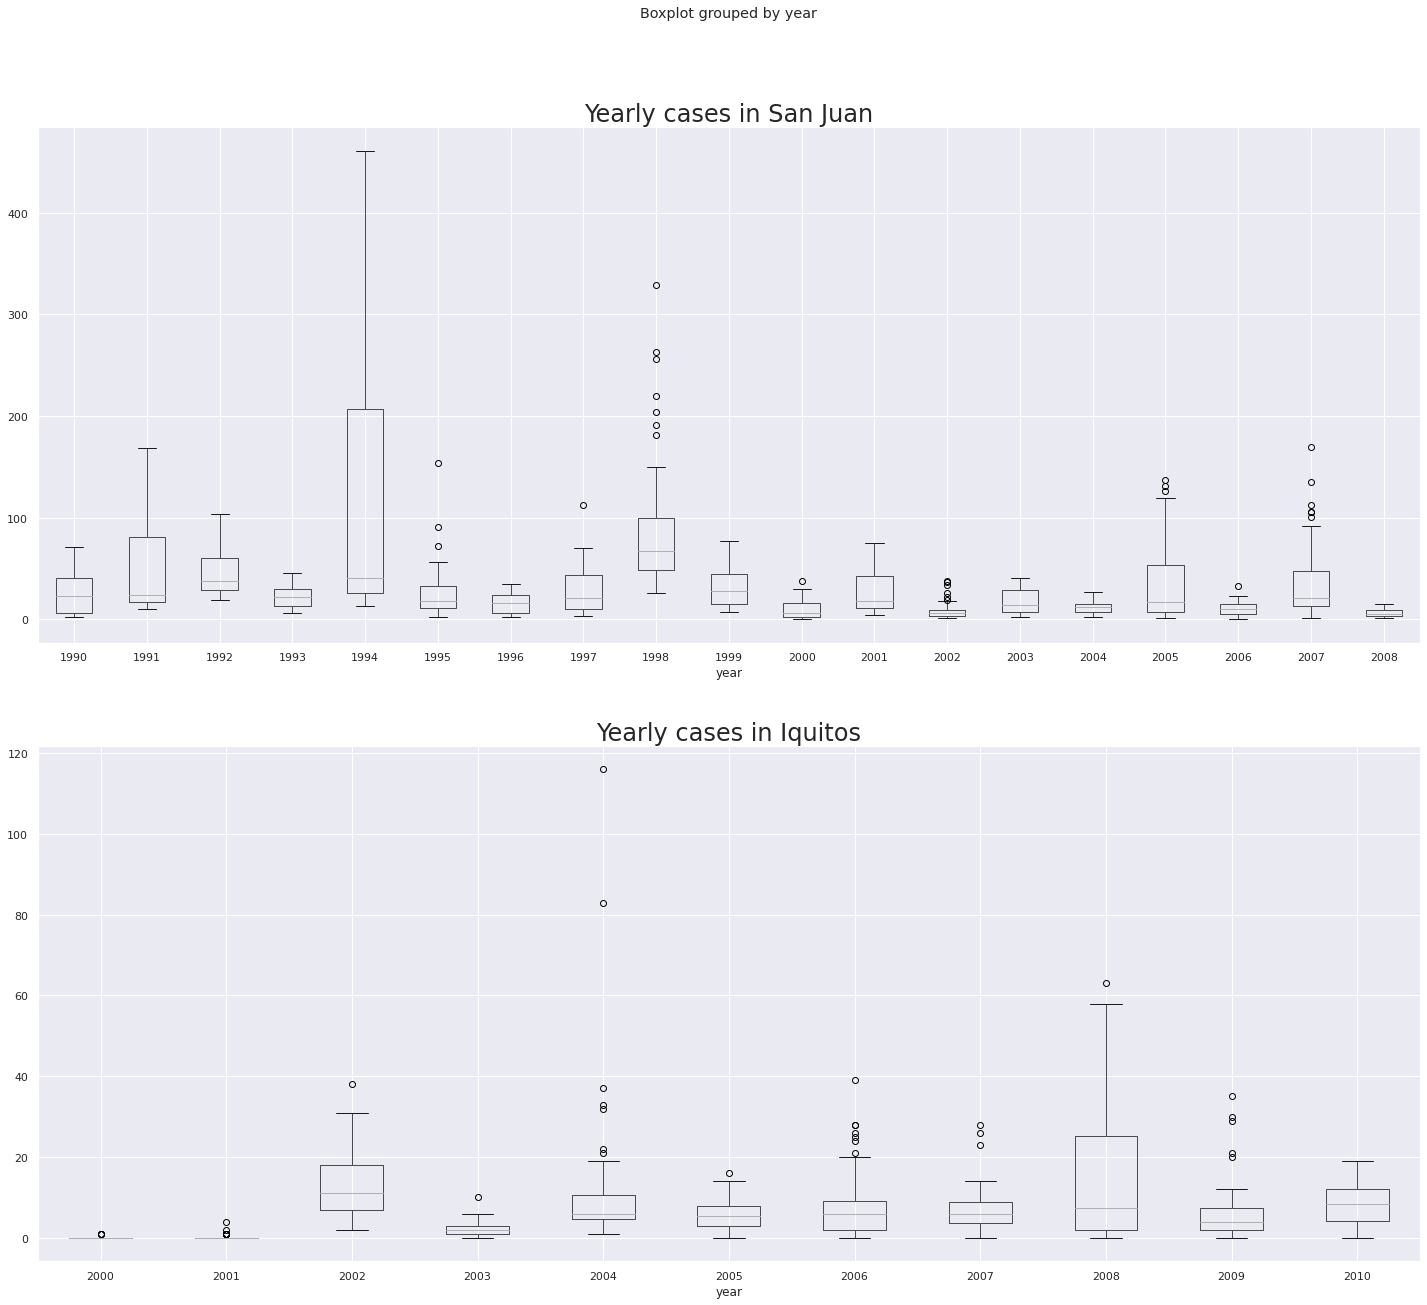

In [15]:
#box plot for  every year
plt.rcParams["figure.figsize"] = 24,21

#2 subplots
fig,axs = plt.subplots(2,1)

#number of cases every year
df_sj.boxplot(by='year',column=['total_cases'],ax=axs[0])
axs[0].set_title("Yearly cases in San Juan",size=24)

df_iq.boxplot(by="year",column=["total_cases"],ax=axs[1])
axs[1].set_title("Yearly cases in Iquitos",size=24)

plt.show()

In [16]:
df_sj.head()

,city,year,weekofyear,total_cases,yearly_cases
0,sj,1990,18,4,866
1,sj,1990,19,5,866
2,sj,1990,20,4,866
3,sj,1990,21,3,866
4,sj,1990,22,6,866


## Understanding the distribution of data for *total number of cases* of both the cities,*specific humidity*,*air temperature* and *total number of cases*

/home/dhruval/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


KeyError: 'reanalysis_specific_humidity_g_per_kg'

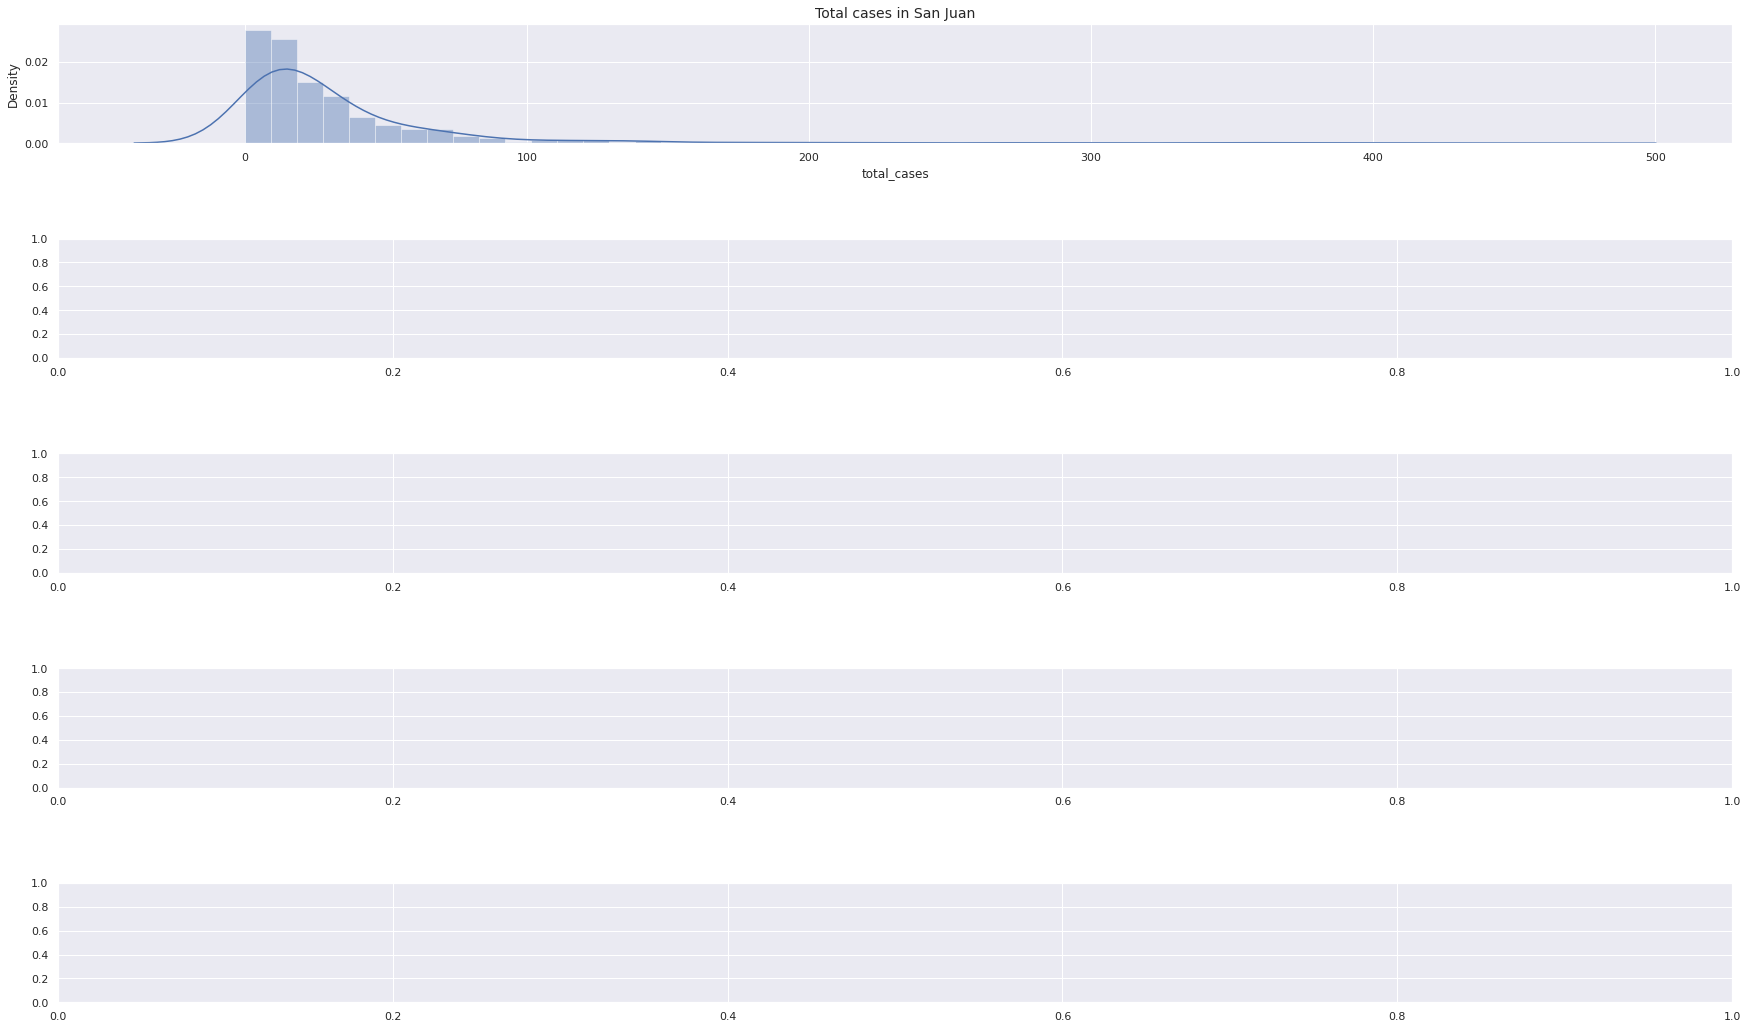

In [17]:
plt.rcParams["figure.figsize"] = 30,18
fig,axs = plt.subplots(5,1)
plt.subplots_adjust(hspace=0.8) #space between plots

#for total number of yearly cases of sj
sns.distplot(df_sj["total_cases"],ax=axs[0])
axs[0].set_title("Total cases in San Juan",size=14)

#humidity
sns.distplot(df_sj["reanalysis_specific_humidity_g_per_kg"],ax=axs[2])
axs[2].set_title("Specific humidity in San Juan",size=14)

#temperature
sns.distplot(df_sj["reanalysis_avg_temp_k"],ax=axs[3])
axs[3].set_title("Air temperature in San Juan",size=14)

#for yearly number of cases in iq
sns.distplot(df_iq["total_cases"],ax=axs[1])
axs[1].set_title("Total cases in Iquitos",size=14)

# #all cases
# sns.distplot(df_cases_time["total_cases"],ax=axs[4])
# axs[4].set_title("Total cases",size=14)

#humidity
sns.distplot(df_iq["reanalysis_specific_humidity_g_per_kg"],ax=axs[2])
axs[2].set_title("Specific humidity in Iquitos",size=14)

#temperature
sns.distplot(df_iq["reanalysis_avg_temp_k"],ax=axs[3])
axs[3].set_title("Air temperature in Iquitos",size=14)

plt.show()

The error is due to missing data point ie missing dates within a week : ValueError: You must specify a freq or x must be a pandas object with a timeseries index with a freq not set to None

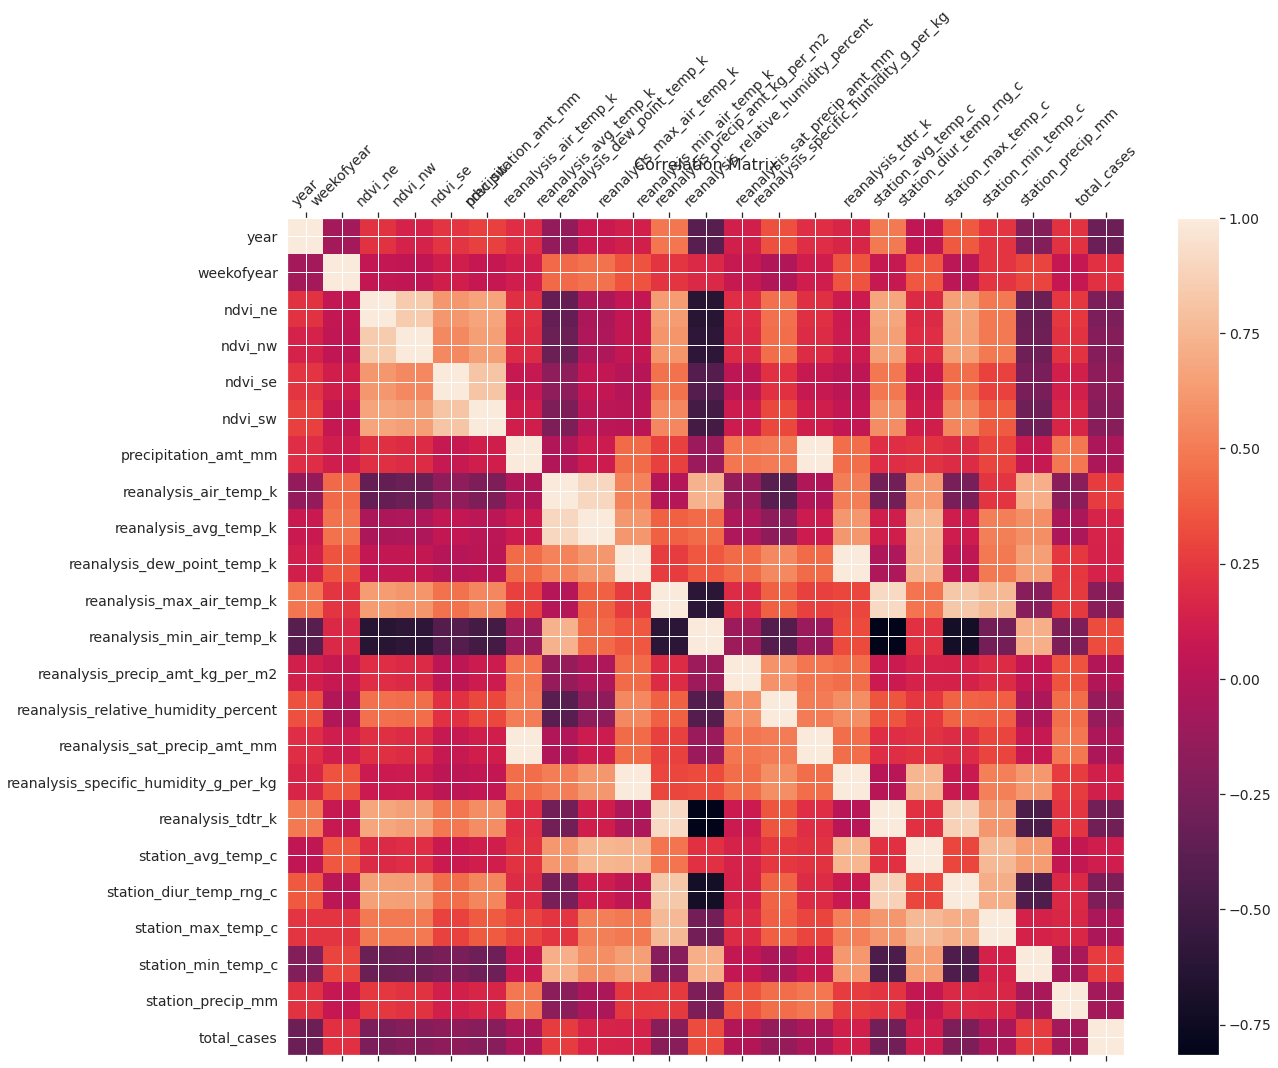

In [ ]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df_cases_time.corr(), fignum=f.number)
plt.xticks(range(df_cases_time.select_dtypes(['number']).shape[1]), df_cases_time.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_cases_time.select_dtypes(['number']).shape[1]), df_cases_time.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);